### Prerequisites

In [1]:
# Install required packages
import numpy as np
import networkx as nx
import matplotlib as plt
import matplotlib.pyplot as pyplt
import copy

from datetime import date
from dataclasses import dataclass
from typing import Callable, List, Optional, Tuple

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

from scipy.optimize import minimize, check_grad
from sklearn.linear_model import LinearRegression, LogisticRegression

### Create nominal problem instance

In [2]:
# Global variables
nr_lctns = 17
nr_vhcls = 4
capacity = 150
smple_sz = 1000
epsilon  = 10e-4
today = date.today()

# Implied variables
nr_trgts = nr_lctns * (nr_lctns-1) + 1
nr_ftres = (nr_lctns-1) + (nr_lctns-1)
nr_ftres_intrcpt = nr_ftres + 1
features = [*range(nr_ftres)]

# Set seed
np.random.seed(42)

In [3]:
# Determine distance matrix from coordinates using a specific metric
def manhattan_dist(coordinates):
    dst_matrix = np.zeros((nr_lctns, nr_lctns), dtype=int)
    for i in range(nr_lctns):
        crd_A = np.array(coordinates[i])
        for j in range(nr_lctns):
            crd_B = np.array(coordinates[j])
            dst_matrix[i][j] = int(np.abs(np.sum(crd_A-crd_B)))
    return dst_matrix

def euclidean_dist(coordinates):
    dst_matrix = np.zeros((nr_lctns, nr_lctns), dtype=int)
    for i in range(nr_lctns):
        crd_A = np.array(coordinates[i])
        for j in range(nr_lctns):
            crd_B = np.array(coordinates[j])
            dst_matrix[i][j] = int(np.linalg.norm(crd_A-crd_B))
    return dst_matrix    

In [4]:
"""Stores the data for the nominal problem."""
data = {}
data['coordinates'] =   [[456, 320], # location 0 - the depot
                        [228, 0],    # location 1
                        [912, 0],    # location 2
                        [0, 80],     # location 3
                        [114, 80],   # location 4
                        [570, 160],  # location 5
                        [798, 160],  # location 6
                        [342, 240],  # location 7
                        [684, 240],  # location 8
                        [570, 400],  # location 9
                        [912, 400],  # location 10
                        [114, 480],  # location 11
                        [228, 480],  # location 12
                        [342, 560],  # location 13
                        [684, 560],  # location 14
                        [0, 640],    # location 15
                        [798, 640]]  # location 16
data["distance_matrix"] = manhattan_dist(data['coordinates'])
data["demands"] = [0, 15, 12, 26, 40, 20, 34, 55, 65, 13, 20, 10, 16, 40, 27, 64, 70]
data["vehicle_capacities"] = [capacity, capacity, capacity, capacity]
data["num_vehicles"] = nr_vhcls
data["depot"] = 0

In [5]:
# Create list of edges in graph
edge_list = []
for i in range(nr_lctns):
    for j in range(nr_lctns):
        if i != j:
            edge_list.append((i,j))

# Set for each node the indices of the edge list 
# corresponding to outgoing or incoming arcs
in_indx_dict  = {}
out_indx_dict = {}

for i in range(nr_lctns):
    in_indx_dict[str(i)]  = []
    out_indx_dict[str(i)] = []

for i in range(len(edge_list)):
    strt = edge_list[i][0]
    out_indx_dict[str(strt)].append(i)
    end = edge_list[i][1]
    in_indx_dict[str(end)].append(i)

In [6]:
# Create one-dim cost vector for vector of arcs using a distance matrix
def dist_list(dst_matrix):
    cost_list = []
    for edge in edge_list:
        cost_list.append(dst_matrix[edge[0]][edge[1]])
    return cost_list    

### Solver

In [7]:
def print_solution(demand, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += demand[node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")

In [8]:
def decoded_VRP_solver(demand, distance_matrix, goal ='all', print = False):
    """
    Solves paramatrized SPP and outputs the desired target
    
    Args:
        demand:             Demand vector
        distance_matrix:    Pairwise distances between locations
        goal:               What to include in output target
        print:              Print solution
        
    Returns:
        target vector
    """
     # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(distance_matrix), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return demand[from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacities"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.FromSeconds(5)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution and print == True:
        print_solution(demand, manager, routing, solution)

    # Decode solution
    total_distance = 0
    total_load = 0
    edges_used = []

    x_vctr = []
    u_vctr = np.zeros(nr_lctns)

    for vehicle_id in range(nr_vhcls):
        index = routing.Start(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += demand[node_index]
            u_vctr[node_index] = route_load
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
            if routing.IsEnd(index):
                edges_used.append((previous_index, 0))
            elif routing.IsStart(previous_index):
                edges_used.append((0, index))
            else:
                edges_used.append((previous_index, index))

        total_distance += route_distance
        total_load += route_load

    for edge in edge_list:
        if edge in edges_used:
            x_vctr.append(1)
        else:
            x_vctr.append(0)

    if goal == 'all':
        return total_distance, u_vctr, x_vctr
    
    elif goal == 'objective':
        return total_distance
    
    else:
        AssertionError('goal value not supported')


In [9]:
total_distance, u_vctr, x_vctr = decoded_VRP_solver(demand=data['demands'], distance_matrix=data['distance_matrix'], print=True)

Objective: 3352
Route for vehicle 0:
 0 Load(0) ->  9 Load(13) ->  14 Load(40) ->  10 Load(60) ->  16 Load(130) ->  2 Load(142) ->  0 Load(142)
Distance of the route: 1324m
Load of the route: 142

Route for vehicle 1:
 0 Load(0) ->  1 Load(15) ->  4 Load(55) ->  3 Load(81) ->  7 Load(136) ->  11 Load(146) ->  0 Load(146)
Distance of the route: 1392m
Load of the route: 146

Route for vehicle 2:
 0 Load(0) ->  13 Load(40) ->  8 Load(105) ->  6 Load(139) ->  0 Load(139)
Distance of the route: 364m
Load of the route: 139

Route for vehicle 3:
 0 Load(0) ->  5 Load(20) ->  12 Load(36) ->  15 Load(100) ->  0 Load(100)
Distance of the route: 272m
Load of the route: 100

Total distance of all routes: 3352m
Total load of all routes: 527


### Constraints
Capacity constraints:
$$d_j\leq u_j\leq C \qquad j\in[n]$$
Flow constraints:
$$\sum_{j=1}^n x_{1j}, \sum_{j=1}^n x_{j1} \leq m$$
$$\sum_{k=0, k\neq j}^n x_{jk}=1 \qquad j\in[n]$$
$$\sum_{j=0, j\neq k}^n x_{jk}=1 \qquad k\in[n]$$
Subtour elemination constraints:
$$u_j-u_j+Cx_{jk}\leq C-d_k \qquad j,k \in[n]; j\neq k$$

In [10]:
# Capacity constraints
def cap_constraints(u, d, capacity):
    constr_lst = []
    u = np.array(u)
    d = np.array(d)
    for i in range(nr_lctns):
        c0 = np.maximum(np.zeros(len(d)), d[:,i]-u[:,i])
        c1 = np.maximum(np.zeros(len(d)), u[:,i]-capacity*np.ones(len(d)))
        constr_lst.append(c0)
        constr_lst.append(c1)
    return np.transpose(np.array(constr_lst))

# Flow constraints
def flow_constraints(x):
    constr_lst = []
    x = np.array(x)
    for i in range(nr_lctns):
        if i == 0:
            constr_lst.append(np.maximum(np.zeros(len(x)), sum(x[:,j] for j in out_indx_dict[str(i)]) - nr_vhcls * np.ones(len(x))))
            constr_lst.append(sum(x[:,j] for j in out_indx_dict[str(i)]) -  sum(x[:,k] for k in  in_indx_dict[str(i)]))
        else:
            constr_lst.append(sum(x[:,j] for j in out_indx_dict[str(i)]) - np.ones(np.shape(x[:,0])))
            constr_lst.append(sum(x[:,j] for j in  in_indx_dict[str(i)]) - np.ones(np.shape(x[:,0])))

    return np.transpose(np.array(constr_lst))

# Subtour elimination constraints
def subtour_constraints(x, u, d, capacity):
    constr_lst = []
    x = np.array(x)
    u = np.array(u)
    d = np.array(d)
    for i in range(len(edge_list)):
        edge = edge_list[i]
        strt = edge[0]
        end  = edge[1]
        if strt != 0 and end != 0:
            c = np.maximum(np.zeros(len(x)), u[:,strt] - u[:,end] + capacity * x[:,i] - (capacity *np.ones(len(x))- d[:,end]))
            constr_lst.append(c)
        else:
            constr_lst.append(np.zeros(len(x)))
    return np.transpose(np.array(constr_lst))

# Indicators used for Jacobian
indicators = np.zeros((2*nr_lctns, len(edge_list)))
for i in range(nr_lctns):
    for j in out_indx_dict[str(i)]:
        indicators[int(2*i)][j]  = 1.0
    for j in  in_indx_dict[str(i)]:
        if i == 0:
            indicators[int(2*i+1)][j] = -1.0 
        else:
            indicators[int(2*i+1)][j] = 1.0

# Help functions for Jacobian of coherence error regarding feasible region
def jac_flow_constraints(x):
    constr_lst = flow_constraints(x)
    jac_flow_lst = np.matmul(constr_lst, indicators)
    return jac_flow_lst

def jac_subtour_constraints(x, u, d, capacity):
    return capacity*(subtour_constraints(x, u, d, capacity) > 0)

### Experiment
Explaining objective value + depot incoming arcs nominal problem 
Parameter: demand, distance/cost locations to depot 

In [11]:
node_of_interest = 0

### Dataset creation

In [12]:
# Set of help function to create a sample train set for the model

# Sample parameter components using a normal perturbation while checking if problem remains feasible
def sample_perturbations_normal(orig, mean = 0, var = 0.2, size = 1000, feasibility_check = True):
    
    org_plus_prtb = [orig]
    cntr = 1

    while cntr < size:
        orig_with_noise = copy.deepcopy(orig)
        good_sample = True
        
        for j in range(len(orig)):
            lcl_var = orig_with_noise[j] * var
            orig_with_noise[j] = int(orig_with_noise[j] + np.random.normal(mean, lcl_var))

        if feasibility_check:       # Rule-of-thumb 
            good_sample = good_sample * (np.sum(orig_with_noise) <= capacity * 0.8 * nr_vhcls)

        if good_sample == True:
            org_plus_prtb.append(np.asarray(orig_with_noise))
            cntr  = cntr + 1
        
    org_plus_prtb = np.asarray(org_plus_prtb)

    return org_plus_prtb

# Get values from samples
def get_values_from_samples(smpls, model_lcl, hyperprm = {}):
    values = []
    for smpl in smpls:
        values.append(model_lcl(demand = smpl, **hyperprm))
    return values

# Determine weight of samples
def std_weight_function(a, b, ftr_index_list, kernel_width = None):
    d = np.linalg.norm(a - b)
    if kernel_width is None:
        krnl_wdth = 0.75 * len(ftr_index_list)
    else:
        krnl_wdth = kernel_width
    return np.exp(-(d ** 2) / (2* krnl_wdth ** 2))
    
def get_weights_from_samples(smpls, ftr_index_list, function = None, width = None):
    org = smpls[0]
    weights = []
    for smpl in smpls:
        if function is not None:
            weights.append(function(org, smpl))
        else:
            weights.append(std_weight_function(org, smpl, ftr_index_list, width))
    return weights

In [13]:
# Sigmoid function for logistic regression
def sig(x):
    safe_x = np.asarray(x)  
    result = np.empty_like(safe_x, dtype=float)
    
    # Cap off sigmoid function outside [-30,30]
    result[safe_x > 30]  = 1
    result[safe_x < -30] = 0
    mask = (safe_x >= -30) & (safe_x <= 30)
    result[mask] = 1 / (1 + np.exp(-safe_x[mask]))

    return result

# Help function for the log loss computation
# Calculates ln(pred(y))
def lg1(x):
    safe_x = np.asarray(x) 
    result = np.empty_like(safe_x, dtype=float)
    
    # Account for cap off sigmoid function outside [-30,30]
    result[safe_x > 30]  = 0
    result[safe_x < -30] = np.log(1 / (1 + np.exp(30)))
    mask = (safe_x >= -30) & (safe_x <= 30)
    result[mask] = np.log(1 / (1 + np.exp(-safe_x[mask])))

    return result

# Help function for the log loss computation
# Calculates ln(1-pred(y))
def lg2(x):
    safe_x = np.asarray(x)  
    result = np.empty_like(safe_x, dtype=float)
    
    # Account for cap off sigmoid function outside [-30,30]
    result[safe_x < -30] = 0
    result[safe_x > 30]  = np.log(1 - 1 / (1 + np.exp(-30)))
    mask = (safe_x >= -30) & (safe_x <= 30)
    result[mask] = np.log(1 - (1 / (1 + np.exp(-safe_x[mask]))))
    
    return result

In [14]:
# Create dataset to train model on

# Compute samples (theta)
samples_dmnd_all = sample_perturbations_normal(data['demands'], size=smple_sz)
samples_dstn_noi = sample_perturbations_normal(data['distance_matrix'][node_of_interest], size=smple_sz, feasibility_check=False)
samples_dist_mtrx    = []  # Update distance matrices accordingly
samples_dist_list    = []  # Update 1-dim distance vector
samples_dstn_noi_wo  = []  # Set distances without depot to use as features

for sample_dstn in samples_dstn_noi:
    lcl_dstn = data['distance_matrix'].copy()
    lcl_dstn[node_of_interest] = sample_dstn
    lcl_dstn[:,node_of_interest] = sample_dstn
    samples_dist_mtrx.append(lcl_dstn)
    samples_dist_list.append(dist_list(lcl_dstn))
    samples_dstn_noi_wo.append(lcl_dstn[node_of_interest][1:])

samples_ftrs = np.concatenate((samples_dmnd_all[:,1:], samples_dstn_noi_wo), axis = 1) 
samples_dist_list = np.array(samples_dist_list)

In [15]:
features = [*range(nr_ftres)]

# Compute targets (actuals)
actuals = {}
actuals['objct'] = []
actuals['x_vct'] = []
actuals['u_vct'] = []

# Compute distances to nominal problem
d_list = []
j=0
for i in range(len(samples_ftrs)):
    sample_ftrs = samples_ftrs[i]
    sample_dmnd = samples_dmnd_all[i]
    sample_dist_mtrx = samples_dist_mtrx[i]
    if sum(sample_dmnd) >= capacity * nr_vhcls:
        print('Oh no')
    objct_lcl, u_vct_lcl, x_vct_lcl = decoded_VRP_solver(demand=sample_dmnd, distance_matrix=sample_dist_mtrx)
    actuals['objct'].append(objct_lcl)
    actuals['x_vct'].append(x_vct_lcl)
    actuals['u_vct'].append(u_vct_lcl)
    j=j+1

    d_list.append(np.linalg.norm(samples_ftrs[0] - sample_ftrs))
    if j % int(smple_sz/10)==0:
        print(f"{np.round(100 * i/smple_sz,2)}% done.")

# Compute weights of samples
weights = get_weights_from_samples(samples_ftrs, features, width=np.mean(d_list))

9.9% done.
19.9% done.
29.9% done.
39.9% done.
49.9% done.
59.9% done.
69.9% done.
79.9% done.
89.9% done.
99.9% done.


In [16]:
# Rescale data for quicker minimizaation, does not effect relative feature contribution
samples_ftrs = np.array(samples_ftrs)/100
samples_ftrs_intrcpt = np.array(np.concatenate((samples_ftrs, np.ones((smple_sz,1))), axis =1))
samples_dist_list = np.array(samples_dist_list)/1000

actuals['objct'] = np.array(actuals['objct'])/1000
actuals['x_vct'] = np.array(actuals['x_vct'])
actuals['u_vct'] = np.array(actuals['u_vct'])/100

In [17]:
# Find depot incoming arcs nominal problem and store corresponding indices to explain
print('Incoming arcs nominal problem solved with OR-tools of Google')
kc_indx = []
for i in in_indx_dict[str(node_of_interest)]:
    if actuals['x_vct'][0][i] == 1:
        print(edge_list[i])
        kc_indx.append(i)
print('Indices in edge decision vector:', kc_indx)

Incoming arcs nominal problem solved with OR-tools of Google
(2, 0)
(6, 0)
(11, 0)
(15, 0)
Indices in edge decision vector: [32, 96, 176, 240]


### Warm start

In [18]:
trgt_indx = np.concatenate(([0],kc_indx))

def get_warm_start_linreg(X, Y, W, trgt_indx):
    """
    Obtain a warm start for finding surrogate models (minimizing lss_all) 
    using regression models without any regulazers

    Args:
        X:              Parameters (excl. intercept) of sample data set (dim(#features, sample size))
        Y:              Targets of sample data set (dim(1 + #decision variables, sample size))
        W:              Weights of the samples (dim(sample size))
        trgt_indx:      Indices of target variable we explain and want a warm start for
        
    Returns:
        wrm_strt:       Model parameters of standard regression models (dim(#features + 1, #targets))
        kc_indx_revw:   Reviewed indices of target variable we explain, removed decision variables that have one value only in dataset
    """

    models = []
    kc_indx_revw = []
    X = np.array(X)
    cnt = 0
    for i in trgt_indx:
        if i == 0 and cnt == 0:
            Y_loc = np.array(Y['objct'])
        else:
            Y_loc = np.array([z[i] for z in Y['x_vct']])

        # Objective: use LinearRegression
        if i == 0 and cnt == 0:
            clf = LinearRegression()
            clf.fit(X, Y_loc, sample_weight = W)
            models.append(clf)
       
        # Decision variables: binary, use LinearRegression if
        # samples contain both 0 and 1 values, fix parameters otherwise
        elif np.sum(Y_loc) == len(Y_loc):
            print('All 0 for edge', edge_list[i])
        elif np.sum(Y_loc) == 0:
            print('All 0 for edge', edge_list[i])
        else:
            clf = LogisticRegression(max_iter=10000)
            Y_loc_int = [int(item) for item in Y_loc]
            clf.fit(X, Y_loc_int, sample_weight = W)
            kc_indx_revw.append(i)
            models.append(clf)
        cnt = cnt+1

    # Extract parameters from fitted models
    wrm_strt_t = np.zeros((len(models), nr_ftres_intrcpt))
    for i in range(len(models)):
        if any(isinstance(item, np.ndarray) for item in models[i].coef_):
            for j in range(len(features)):
                wrm_strt_t[i][j] = models[i].coef_[0][j]
            wrm_strt_t[i][j+1] = models[i].intercept_[0]
        else:
            for j in range(len(features)):
                wrm_strt_t[i][j] = models[i].coef_[j]
            wrm_strt_t[i][j+1] = models[i].intercept_
    wrm_strt = np.transpose(wrm_strt_t)
    return wrm_strt, kc_indx_revw

wrm_strt_lcl, kc_indx_revw = get_warm_start_linreg(samples_ftrs, actuals, weights, trgt_indx)

In [19]:
np.shape(samples_dist_list)

(1000, 272)

### Loss functions

In [20]:
def lss_all(beta, X = samples_ftrs_intrcpt, Y = actuals, W = weights, lgr_std = 1, lgr_log = 1, lgr_obj = 1, lgr_cns = 1, oneD=True, C = samples_dist_list, keep_columns=kc_indx_revw):
    """
    Functions for the total empircal loss at surrogates/explanations using beta parameters

    Args:
        beta:           Beta parameter for surrogate model
        X:              Parameters (incl. intercept) of sample data set (dim(sample size, #features + 1))
        Y:              Targets of sample data set (dictionary)
        W:              Weights of the samples (dim(sample size))
        lgr_...:        Scalar for various components of total loss
        oneD:           Boolean whether beta is passed on as an one-dim vector (True) or as a matrix (False)
        C:              Cost matrix to calculate objective using decision vector (dim(sample size, #decision variables))
        keep_columns:   Indices of decision vector to keep to predict and calculate loss for
        
    Returns:
        tot_err:        Total weighted loss
    """

    # Transform beta to matrix for matrix calculations
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt, len(keep_columns)+1)

    W = np.array(W)
    X = np.array(X)
    X_demand = np.hstack((np.zeros((len(X), 1)), X[:, :nr_lctns-1]))
    Y_objct = np.array(Y['objct'])
    Y_x_vct = np.array(Y['x_vct'])
    Y_u_vct = np.array(Y['u_vct'])
    Y_x_vct_kp = Y_x_vct[:,keep_columns]        # Only calulate loss for the decision variables we predict
    
    obj_prd = np.matmul(X, beta)[:,0]           # Predictions objective value    
    dcv_prd = sig(np.matmul(X, beta))[:,1:]     # Predictions decision vector
    dcv_lg1 = (lg1(np.matmul(X, beta)[:,1:]))   # ln(Predictions decision vector)
    dcv_lg2 = (lg2(np.matmul(X, beta)[:,1:]))   # ln(1 - Predictions decision vector)

    # Replace predictions with actuals for decision variables not in keep_columns, not explained
    dcv_cmb = Y_x_vct.copy().astype(float) 
    columns_to_replace = np.zeros(len(Y_x_vct[0]), dtype=bool)
    columns_to_replace[keep_columns] = True
    dcv_cmb[:, columns_to_replace] = dcv_prd

    # Constraint errors
    cns_arr_flow = flow_constraints(dcv_cmb)
    cns_arr_capc = cap_constraints(Y_u_vct, X_demand, capacity=1.5)
    cns_arr_sbtr = subtour_constraints(dcv_cmb, Y_u_vct, X_demand, capacity=1.5)
     
    # Calculate various weighted losses 
    std_err =  np.sum(np.matmul(np.diag(W), np.square(Y_objct - obj_prd)))
    log_err = -np.sum(np.matmul(np.diag(W), np.multiply(Y_x_vct_kp, dcv_lg1)+np.multiply((np.ones(np.shape(dcv_lg2))-Y_x_vct_kp),dcv_lg2)))
    obj_err =  np.sum(np.matmul(np.diag(W), np.square(obj_prd-np.sum(np.multiply(dcv_cmb, C), axis=1))))
    cns_err =  np.sum(np.matmul(np.diag(W), np.square(cns_arr_flow))) + np.sum(np.matmul(np.diag(W),np.square(cns_arr_capc))) + np.sum(np.matmul(np.diag(W),cns_arr_sbtr))

    # Weighted sum of the various losses
    tot_err = lgr_std * std_err + lgr_cns * cns_err + lgr_log * log_err + lgr_obj * obj_err
    return tot_err

def lss_all_jac_sg(beta, X = samples_ftrs_intrcpt, Y = actuals, W = weights, lgr_std = 1, lgr_log = 1, lgr_obj = 1, lgr_cns = 1, oneD=True, C = samples_dist_list, keep_columns=kc_indx_revw):
    """
    Functions that outputs Jacobian/subgradient of lss_all function at beta

    Args:
        beta:           Beta parameter for surrogate model
        X:              Parameters (incl. intercept) of sample data set (dim(sample size, #features + 1))
        Y:              Targets of sample data set (dim(sample size, 1 + #decision variables))
        W:              Weights of the samples (dim(sample size))
        lgr_...:        Scalar for various components of total loss
        oneD:           Boolean whether beta is passed on as an one-dim vector (True) or as a matrix (False)
        C:              Cost matrix to calculate objective using decision vector (dim(sample size, #decision variables))
        keep_columns:   Indices of decision vector to keep to predict and calculate loss for
        
    Returns:
        grad_flat: One-dimensional Jacobian/subgradient of lss_all function at beta
    """
    
    grad = np.zeros((nr_ftres_intrcpt, len(keep_columns)+1))        # Initialize gradient as zero-vector
        
    # Transform beta to matrix for matrix calculations
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt, len(keep_columns)+1)

    W = np.array(W)
    X = np.array(X)
    X_demand = np.hstack((np.zeros((len(X), 1)), X[:, :nr_lctns-1]))
    Y_objct = np.array(Y['objct'])
    Y_x_vct = np.array(Y['x_vct'])
    Y_u_vct = np.array(Y['u_vct'])
    Y_x_vct_kp = Y_x_vct[:,keep_columns]
    C_kp = C[:,keep_columns]
    
    obj_prd = np.matmul(X, beta)[:,0]           # Predictions objective value
    dcv_prd = (sig(np.matmul(X, beta)))[:,1:]   # Predictions decision vector

    # Replace predictions with actuals for decision variables not in keep_columns, not explained
    dcv_cmb = Y_x_vct.copy().astype(float) 
    columns_to_replace = np.zeros(len(Y_x_vct[0]), dtype=bool)
    columns_to_replace[keep_columns] = True # Replace columns which we predict
    dcv_cmb[:, columns_to_replace] = dcv_prd

    # Vectors containing chain rule factors for gradient of different errors
    tmp_std = (Y_objct  - obj_prd)
    tmp_obj = (obj_prd - np.sum(np.multiply(dcv_cmb, C), axis=1))
    tmp_cns_flow = jac_flow_constraints(dcv_cmb)[:,keep_columns]
    tmp_cns_sbtr = jac_subtour_constraints(dcv_cmb, Y_u_vct, X_demand, capacity=1.5)[:,keep_columns]

    for k in range(len(grad)):
        for j in range(len(grad[0])):
            if j == 0:      # objective value
                grad[k][j] = grad[k][j] - 2 * lgr_std * (sum(W[i] * X[i][k] * tmp_std[i] for i in range(len(X))))   # accuracy error
                grad[k][j] = grad[k][j] + 2 * lgr_obj * (sum(W[i] * X[i][k] * tmp_obj[i] for i in range(len(X))))   # coherence objective error
            else:           # decision vector
                grad[k][j] = grad[k][j] - lgr_log * (np.abs(beta[k][j])<30 )*(sum(W[i] * X[i][k] * (Y_x_vct_kp[i][j-1]-dcv_prd[i][j-1]) for i in range(len(X))))            # accuracy error
                grad[k][j] = grad[k][j] - 2 * lgr_obj * (sum(dcv_prd[i][j-1] * (1-dcv_prd[i][j-1]) * X[i][k] * C_kp[i][j-1] * W[i] * tmp_obj[i] for i in range(len(X))))    # coherence objective error
                grad[k][j] = grad[k][j] + 2 * lgr_cns * (sum(W[i] * dcv_prd[i][j-1] * (1-dcv_prd[i][j-1]) * X[i][k] * tmp_cns_flow[i][j-1] for i in range(len(X))))         # coherence feasibile region error
                grad[k][j] = grad[k][j] + lgr_cns * (sum(dcv_prd[i][j-1] * (1-dcv_prd[i][j-1]) * X[i][k] * W[i] * tmp_cns_sbtr[i][j-1] for i in range(len(X))))             # coherence feasibile region error
    grad_flat = grad.flatten()  # make one-dimensional
    return grad_flat

In [21]:
"""
Functions for the four components of the loss function seperately

Args:
    beta:           Beta parameter for surrogate model
    X:              Parameters (incl. intercept) of sample data set (dim(sample size, #features + 1))
    Y:              Targets of sample data set (dim(sample size, 1 + #decision variables))
    W:              Weights of the samples (dim(sample size))
    lgr_...:        Scalar for various components of total loss
    oneD:           Boolean whether beta is passed on as an one-dim vector (True) or as a matrix (False)
    C:              Cost matrix to calculate objective using decision vector (dim(sample size, #decision variables))
    keep_columns:   Indices of decision vector to keep to predict and calculate loss for
        
Returns:
    Loss values
"""
# Accuracy loss of objective value: weighted squared loss
def lss_std(beta, X = samples_ftrs_intrcpt, Y = actuals, W = weights, oneD=True, keep_columns=kc_indx_revw):
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt, len(keep_columns)+1)

    W = np.array(W)
    X = np.array(X)
    Y_objct = np.array(Y['objct'])

    obj_prd = np.matmul(X, beta[:,0])
    return np.sum(np.matmul(np.diag(W), np.square(Y_objct - obj_prd)))

# Accuracy loss of decision vector: weighted log loss
def lss_log(beta, X = samples_ftrs_intrcpt, Y = actuals, W = weights, oneD=True, keep_columns=kc_indx_revw):
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt, len(keep_columns)+1)

    W = np.array(W)
    X = np.array(X)
    Y_x_vct = np.array(Y['x_vct'])
    Y_x_vct_kp = Y_x_vct[:,keep_columns]    # Only calulate loss for the variables we predict
    
    dcv_lg1 = lg1(np.matmul(X, beta)[:,1:])
    dcv_lg2 = lg2(np.matmul(X, beta)[:,1:])

    return -np.sum(np.matmul(np.diag(W),(np.multiply(Y_x_vct_kp,dcv_lg1)+np.multiply((np.ones(np.shape(dcv_lg2))-Y_x_vct_kp),dcv_lg2))))

# Coherency loss for objective value: weighted squared loss
def lss_obj(beta, X = samples_ftrs_intrcpt, Y = actuals, W = weights, oneD=True, C = samples_dist_list, keep_columns=kc_indx_revw):
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt, len(keep_columns)+1)

    W = np.array(W)
    X = np.array(X)
    Y_x_vct = np.array(Y['x_vct'])
    
    obj_prd = np.matmul(X, beta)[:,0]
    dcv_prd = (sig(np.matmul(X, beta)))[:,1:]

    # Replace predictions with actuals for decision variables not in keep_columns, not explained
    dcv_cmb = Y_x_vct.copy().astype(float) 
    columns_to_replace = np.zeros(len(Y_x_vct[0]), dtype=bool)
    columns_to_replace[keep_columns] = True 
    dcv_cmb[:, columns_to_replace] = dcv_prd

    return np.sum(np.matmul(np.diag(W),np.square(obj_prd-np.sum(np.multiply(dcv_cmb, C), axis=1))))

# Coherency loss for feasible region: weighted squared and hinge loss
def lss_cns(beta, X = samples_ftrs_intrcpt, Y = actuals, W = weights, oneD=True, keep_columns=kc_indx_revw):
    if oneD == True:
        beta = beta.reshape(nr_ftres_intrcpt, len(keep_columns)+1)

    W = np.array(W)
    X = np.array(X)
    X_demand = np.hstack((np.zeros((len(X), 1)), X[:, :nr_lctns-1]))
    Y_x_vct = np.array(Y['x_vct'])
    Y_u_vct = np.array(Y['u_vct'])

    dcv_prd = (sig(np.matmul(X, beta)))[:,1:]
    # Replace predictions with actuals for decision variables not in keep_columns, not explained
    dcv_cmb = Y_x_vct.copy().astype(float) 
    columns_to_replace = np.zeros(len(Y_x_vct[0]), dtype=bool)
    columns_to_replace[keep_columns] = True # Replace columns which we predict
    dcv_cmb[:, columns_to_replace] = dcv_prd

    # Constraint errors
    cns_arr_flow = flow_constraints(dcv_cmb)
    cns_arr_capc = cap_constraints(Y_u_vct, X_demand, capacity=1.5)
    cns_arr_sbtr = subtour_constraints(dcv_cmb, Y_u_vct, X_demand, capacity=1.5)

    cns_err = np.sum(np.matmul(np.diag(W),np.square(cns_arr_flow)))
    cns_err = cns_err + np.sum(np.matmul(np.diag(W),np.square(cns_arr_capc)))
    cns_err = cns_err + np.sum(np.matmul(np.diag(W),cns_arr_sbtr))

    return cns_err

In [22]:
# Calculate all losses with warm start parameters
lcl_lss_all = lss_all(wrm_strt_lcl)
lcl_lss_std = lss_std(wrm_strt_lcl)
lcl_lss_log = lss_log(wrm_strt_lcl)
lcl_lss_obj = lss_obj(wrm_strt_lcl)
lcl_lss_cns = lss_cns(wrm_strt_lcl)

print('All', lcl_lss_all)
print('Std', lcl_lss_std)
print('Log', lcl_lss_log)
print('Obj', lcl_lss_obj)
print('Cns', lcl_lss_cns)

All 2026.5500141250286
Std 4.241521571342737
Log 1207.4161883434163
Obj 12.347244188559653
Cns 802.5450600217098


In [23]:
# Check the correctness of a gradient function by comparing it against a (forward) finite-difference approximation of the gradient.
print('Error jacobian using subgradient: ', check_grad(lss_all, lss_all_jac_sg, wrm_strt_lcl.flatten()))

Error jacobian using subgradient:  0.0016391608522854217


In [24]:
# Set functions to call loss function + gradient for set weights for different losses
def lss_all_input(input, lmb_1, lmb_2, lmb_3, lmb_4):
    return lss_all(beta = input, lgr_std=lmb_1, lgr_log=lmb_2, lgr_obj=lmb_3, lgr_cns=lmb_4, keep_columns=kc_indx_revw)

def lss_all_jac_input(input, lmb_1, lmb_2, lmb_3, lmb_4):
    return lss_all_jac_sg(beta = input, lgr_std=lmb_1, lgr_log=lmb_2, lgr_obj=lmb_3, lgr_cns=lmb_4, keep_columns=kc_indx_revw)

In [25]:
# Set scalars based on warm start to balance various losses
lss_list  = [lcl_lss_std, lcl_lss_log, lcl_lss_obj, lcl_lss_cns]
max_lss_i = np.argmax(lss_list) 

lmb_lst = np.ones(4)
for i in range(4):
    if max_lss_i != i and lss_list[i] >0.01:
        lmb_lst[i] = min(1e10,lss_list[max_lss_i]/lss_list[i])

args_RLR = (lmb_lst[0], lmb_lst[1], lmb_lst[2], lmb_lst[3])

### Minimize loss function

In [26]:
@dataclass
class OptimizationHistory:
    """Store optimization history including the best solution found."""
    best_x: np.ndarray
    best_fun: float
    all_best_values: List[float]
    all_best_positions: List[np.ndarray]
    
def create_callback_tracker():
    """Creates a callback function and history object to track optimization progress."""
    history = OptimizationHistory(
        best_x=None,
        best_fun=float('inf'),
        all_best_values=[],
        all_best_positions=[]
    )
    
    def callback(xk):
        """
        Callback function that stores the best solution found so far.
        
        Args:
            xk: Current position in the optimization
        """
        try:
            current_fun = lss_all_input(xk, lmb_1=args_RLR[0], lmb_2=args_RLR[1], lmb_3=args_RLR[2], lmb_4=args_RLR[3])
            
            if current_fun < history.best_fun:
                history.best_fun = current_fun
                history.best_x = xk.copy()
            
            history.all_best_values.append(history.best_fun)
            history.all_best_positions.append(history.best_x.copy())
            if len(history.all_best_values) % 10 == 0:
                print('Iteration:', len(history.all_best_values))

        except Exception as e:
            print(f"Warning: Error in callback: {e}")
        
        return False  # Don't stop optimization
    
    return callback, history

def optimize_with_tracking(
    func: Callable,
    x0: np.ndarray,
    jacob: Callable,
    args_f: dict, 
    max_iter: int = 1000
) -> Tuple[OptimizationHistory, dict]:
    """
    Performs optimization while tracking the best solution found.
    
    Args:
        func: Objective function to minimize
        x0: Initial guess
        jacob:Jacobian of objectibe function
        args_f: additional arguments of func and jac
        max_iter: Maximum number of iterations
        
    Returns:
        history: OptimizationHistory object containing the best solution and history
        result: Original scipy.optimize.minimize result object
    """
    callback, history = create_callback_tracker()
    
    result = minimize(
        func,
        x0,
        args=args_f,
        method='SLSQP',
        jac=jacob,
        callback=callback,
        options={'maxiter': max_iter}
    )
    
    return history, result

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Iteration: 110
Iteration: 120
Iteration: 130
Best value found: 4731.1561213281675
Best position found: [  0.2897624   -1.32323474   2.01166075   7.62686188  -1.00150742
   0.04406649   1.27937924   0.50029879   5.31018561   1.09712678
   0.09191994  -1.54605417  -1.03836003   4.87114977  -0.09326082
   0.08504072  -0.31260921  -0.52113466   1.5674175   -1.74905881
   0.03955484   0.97314022   5.98522674  -0.56613393  -3.53240975
   0.11179245  -0.43089356   1.72039306  -0.44681842   4.04736352
   0.14596602  -0.33245946   0.90615417   2.73072421  -1.36805047
   0.05279058   0.39814962   3.00403222   1.90662712   0.34937463
   0.05268903  -3.06087517  -7.38225194   4.6251879    0.42134851
   0.18314127   4.66311548  -1.35031183  -0.26925461  -0.14628285
   0.24176064   6.40400213   1.63148789   7.77171228  -1.64093053
   0.18066898  -2.05345081  -3

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 4731.1561213281675
       x: [ 2.898e-01 -1.323e+00 ... -1.239e+01 -1.190e+00]
     nit: 131
     jac: [-1.848e-03  1.121e-04 ...  6.671e-04  6.850e-04]
    nfev: 407
    njev: 131

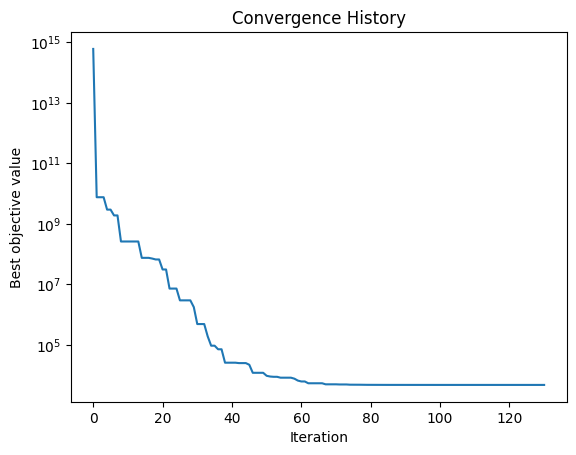

In [27]:
# Minimize loss function
wrm_start_lcl = wrm_strt_lcl.flatten()
history, sol_RLR_lcl = optimize_with_tracking(lss_all_input, wrm_start_lcl, lss_all_jac_input, args_f = args_RLR)

# Access the best solution found
print(f"Best value found: {history.best_fun}")
print(f"Best position found: {history.best_x}")

# Plot the convergence history
pyplt.plot(history.all_best_values)
pyplt.xlabel('Iteration')
pyplt.ylabel('Best objective value')
pyplt.yscale('log')
pyplt.title('Convergence History')

print(f"Best value found: {history.best_fun}")
print(f"Best position found: {history.best_x}")

sol_RLR_lcl

In [28]:
# Select best solution found during minimization process
if sol_RLR_lcl.fun >= history.best_fun:
    sol_final_x   = history.best_x
    sol_final_fun = history.best_fun
else:
    sol_final_x   = sol_RLR_lcl.x
    sol_final_fun = sol_RLR_lcl.fun

In [176]:
print('Total loss with scalars:')
print('Benchmark:', lss_all(wrm_start_lcl, lgr_std=args_RLR[0], lgr_log=args_RLR[1], lgr_obj=args_RLR[2], lgr_cns=args_RLR[3]))
print('New method:', lss_all(sol_final_x, lgr_std=args_RLR[0], lgr_log=args_RLR[1], lgr_obj=args_RLR[2], lgr_cns=args_RLR[3]), '\n')

print('Objective value prediction error:')
print('Unregularized Reg:', lss_std(wrm_start_lcl))
print('Regularized Reg:', lss_std(sol_final_x), '\n')

print('Decision vector prediction error:')
print('Unregularized Reg:', lss_log(wrm_start_lcl))
print('Regularized Reg:', lss_log(sol_final_x), '\n')

print('Objective value relation error:')
print('Unregularized Reg:', lss_obj(wrm_start_lcl))
print('Regularized Reg:', lss_obj(sol_final_x), '\n')

print('Constraint error:')
print('Unregularized Reg:', lss_cns(wrm_start_lcl))
print('Regularized Reg:', lss_cns(sol_final_x), '\n')

Total loss with scalars:
Benchmark: 4829.664753373665
New method: 4731.1561213281675 

Objective value prediction error:
Unregularized Reg: 4.241521571342737
Regularized Reg: 4.242792164630285 

Decision vector prediction error:
Unregularized Reg: 1207.4161883434163
Regularized Reg: 1198.2335487145729 

Objective value relation error:
Unregularized Reg: 12.347244188559653
Regularized Reg: 11.772960758106448 

Constraint error:
Unregularized Reg: 802.5450600217098
Regularized Reg: 780.258695390383 



### Plot results

In [220]:
#feature attribution
edge_to_explain = (2,0)

feature_vals = sol_final_x
feature_vals = np.transpose(feature_vals.reshape(nr_ftres_intrcpt, len(kc_indx_revw)+1))
feature_vals_ete = feature_vals[1]
feature_vals_ete_max = max(np.abs(samples_ftrs[0][i] * feature_vals_ete[i]) for i in range(nr_ftres))

feature_contribution = [0]
feature_magnitude = [0]

for i in range(nr_ftres):
    contr = samples_ftrs[0][i] * feature_vals_ete[i] / feature_vals_ete_max
    feature_contribution.append((contr + 1) /2)
    feature_magnitude.append(np.abs(contr))

cmap = plt.colormaps['seismic']
# Take colors at regular intervals spanning the colormap.
colors = cmap(feature_contribution)
colors[0][0] = 1
colors[0][1] = 1
colors[0][2] = 1
colors[0][3] = 1

In [221]:
feature_names = []
feature_names = np.concatenate((feature_names, ['d'+str(i) for i in range(1,nr_lctns)]))
feature_names = np.concatenate((feature_names, [f"c(0,{i})" for i in range(1,nr_lctns)]))
print(feature_names)
lst = [samples_ftrs[0][i] * feature_vals_ete[i] for i in range(nr_ftres)]
print(lst)

feature_names_sorted = [feature_names for _,feature_names in sorted(zip(np.abs(lst),feature_names))]
lst_sorted = [lst for _,lst in sorted(zip(np.abs(lst),lst))]
print(feature_names_sorted)

['d1' 'd2' 'd3' 'd4' 'd5' 'd6' 'd7' 'd8' 'd9' 'd10' 'd11' 'd12' 'd13'
 'd14' 'd15' 'd16' 'c(0,1)' 'c(0,2)' 'c(0,3)' 'c(0,4)' 'c(0,5)' 'c(0,6)'
 'c(0,7)' 'c(0,8)' 'c(0,9)' 'c(0,10)' 'c(0,11)' 'c(0,12)' 'c(0,13)'
 'c(0,14)' 'c(0,15)' 'c(0,16)']
[np.float64(-0.1984852104246896), np.float64(0.15352550857332184), np.float64(-0.401974085217967), np.float64(-0.12504368394618845), np.float64(0.19462804340498488), np.float64(-0.14650381007558727), np.float64(-0.1828527050714754), np.float64(0.2587972518055467), np.float64(-0.39791377215241824), np.float64(0.9326230957168541), np.float64(0.6404002130312438), np.float64(-0.3285521300300991), np.float64(-0.6539879136726121), np.float64(1.052244788918284), np.float64(0.3023761455828942), np.float64(0.38802398168384966), np.float64(0.9628850986450833), np.float64(-5.348127482793724), np.float64(-0.41316098345048663), np.float64(-1.26664845971559), np.float64(0.49753602404596164), np.float64(0.4831236187997543), np.float64(-0.36021744778957804), np.f

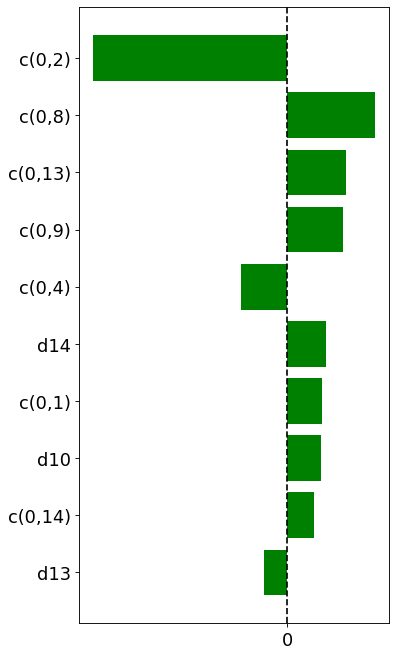

In [225]:
# Draw plot 
pyplt.figure(figsize=(5, 10), dpi=80) 
pyplt.rcParams.update({
    'font.size': 16,              # Base font size
    'axes.labelsize': 16,         # Axis label size
    'xtick.labelsize': 16,        # X-tick label size
    'ytick.labelsize': 16,        # Y-tick label size
    'legend.fontsize': 16,        # Legend text size
})
  
# Plotting the horizontal lines 
pyplt.barh(feature_names_sorted[-10:], lst_sorted[-10:], color = 'green')
pyplt.barh(feature_names_sorted[-10:], lst_sorted[-10:], color = 'green')

pyplt.axvline(x = 0, color = 'black', linestyle = '--')
#hide x-axis
# ax.get_xaxis().set_visible(False)
pyplt.xticks(np.arange(0, 0.9, step=1))
# Displaying the Diverging Bar Chart 
pyplt.show() 

[('1', '0'), ('2', '0'), ('3', '0'), ('4', '0'), ('5', '0'), ('6', '0'), ('7', '0'), ('8', '0'), ('9', '0'), ('10', '0'), ('11', '0'), ('12', '0'), ('13', '0'), ('14', '0'), ('15', '0'), ('16', '0')]


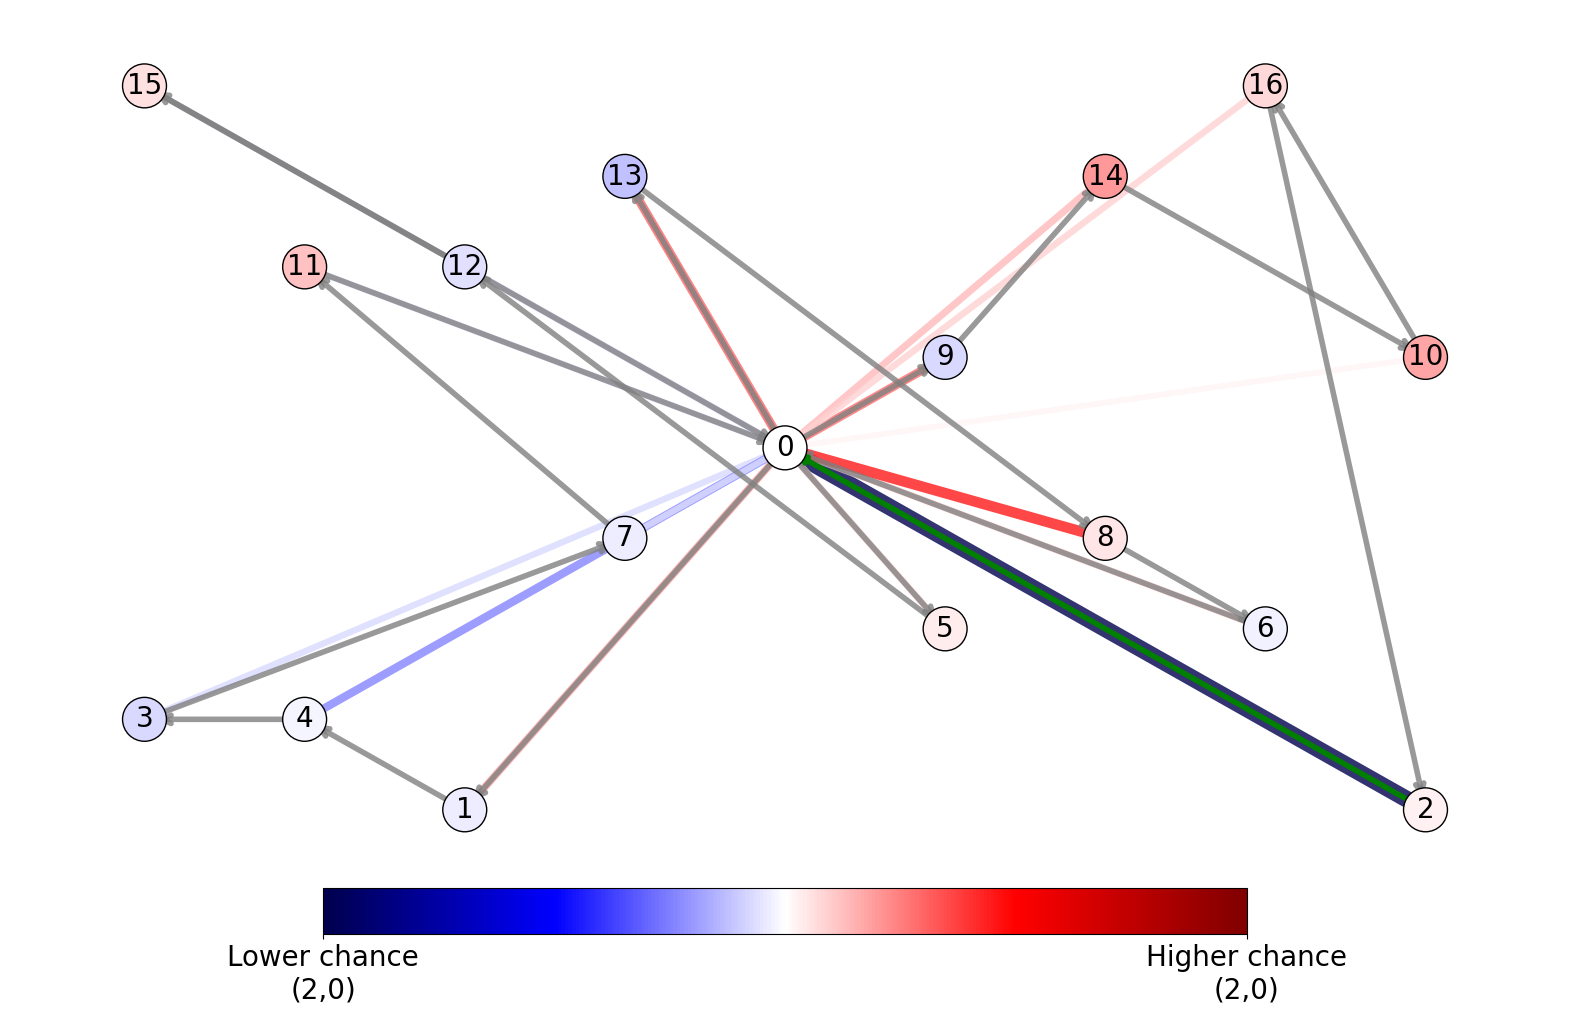

In [224]:
fig, ax = pyplt.subplots(figsize=(20,12))

node_list_g = [*range(nr_lctns)]
node_list_g = [str(i) for i in node_list_g]
edge_list_g_all = []
edge_list_g_org = []
edge_list_g_adj = []
crdn_dict_g = {}

for i in range(len(node_list_g)):
    strt = node_list_g[i]
    crdn_dict_g[strt] = tuple(data['coordinates'][i])
    # print(tuple(data['coordinates'][i]))
    for j in range(len(node_list_g)):
        if i !=j and j == 0:
            edge_list_g_adj.append((str(i),str(j)))

for i in range(len(edge_list)):
    if actuals['x_vct'][0][i] == 1 and edge_list[i][0] !=2:
        edge = (str(edge_list[i][0]), str(edge_list[i][1]))
        edge_list_g_org.append(edge)

color_node = colors[:nr_lctns]
width_node = []
for i in range(nr_lctns):
    width_node.append(400+100*feature_magnitude[i])
width_edge = []
for i in range(nr_lctns, len(feature_contribution)):
    width_edge.append(8* feature_magnitude[i]+4)
color_egde = colors[nr_lctns:]
print(edge_list_g_adj)

G = nx.Graph()
draw = nx.draw_networkx_nodes(G, crdn_dict_g, nodelist =node_list_g, node_size=1000, node_color=color_node, edgecolors = "black")

nx.draw_networkx_edges(
    G,
    pos=crdn_dict_g,
    node_size=1000,
    edgelist=edge_list_g_adj,
    edge_color=color_egde,
    width=width_edge,
    alpha=0.8
)
draw = nx.draw_networkx_edges(
    G,
    pos=crdn_dict_g,
    edgelist=edge_list_g_org,
    edge_color='grey',
    width=4,
    arrows=True,
    arrowstyle="->",
    arrowsize=15,
    alpha=0.8,
)

draw = nx.draw_networkx_edges(
    G,
    pos=crdn_dict_g,
    edgelist=[('2','0')],
    edge_color='green',
    width=4,
    arrows=True,
    arrowstyle="->",
    arrowsize=12,
    alpha=1,
)

labels = {}
for i in range(len(node_list_g)):
    labels[node_list_g[i]] = node_list_g[i]
nx.draw_networkx_labels(G, crdn_dict_g, labels, font_size=20, font_color="black")

cmap = pyplt.cm.seismic
norm = plt.colors.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array

# Add a colorbar to the plot
cbar = pyplt.colorbar(sm,ax=ax, ticks=[-1, 1], orientation='horizontal',fraction=0.05, pad=0.002)
cbar.ax.set_xticklabels(['Lower chance\n(2,0)', 'Higher chance\n(2,0)'], fontsize=20)
ax.axis("off")
cbar.ax.xaxis.set_ticks_position('bottom')
ax.axis("off")
pyplt.show()

In [226]:
#feature attribution objective

feature_vals = sol_final_x
feature_vals = np.transpose(feature_vals.reshape(nr_ftres_intrcpt, len(kc_indx_revw)+1))
feature_vals_ete = feature_vals[0]
feature_vals_ete_max = max(np.abs(samples_ftrs[0][i] * feature_vals_ete[i]) for i in range(nr_ftres))

feature_contribution = [0]
feature_magnitude = [0]

for i in range(nr_ftres):
    contr = samples_ftrs[0][i] * feature_vals_ete[i] / feature_vals_ete_max
    feature_contribution.append((contr + 1) /2)
    feature_magnitude.append(np.abs(contr))
cmap = plt.colormaps['seismic']
# Take colors at regular intervals spanning the colormap.
colors = cmap(feature_contribution)
colors[0][0] = 1
colors[0][1] = 1
colors[0][2] = 1
colors[0][3] = 1

In [227]:
feature_names = []
feature_names = np.concatenate((feature_names, ['d'+str(i) for i in range(1,nr_lctns)]))
feature_names = np.concatenate((feature_names, [f"c(0,{i})" for i in range(1,nr_lctns)]))
print(feature_names)
lst = [samples_ftrs[0][i] * feature_vals_ete[i] for i in range(nr_ftres)]
print(lst)

feature_names_sorted = [feature_names for _,feature_names in sorted(zip(lst,feature_names))]
print(feature_names_sorted)

['d1' 'd2' 'd3' 'd4' 'd5' 'd6' 'd7' 'd8' 'd9' 'd10' 'd11' 'd12' 'd13'
 'd14' 'd15' 'd16' 'c(0,1)' 'c(0,2)' 'c(0,3)' 'c(0,4)' 'c(0,5)' 'c(0,6)'
 'c(0,7)' 'c(0,8)' 'c(0,9)' 'c(0,10)' 'c(0,11)' 'c(0,12)' 'c(0,13)'
 'c(0,14)' 'c(0,15)' 'c(0,16)']
[np.float64(0.04346436044604742), np.float64(0.005287979200416182), np.float64(0.023899184387312703), np.float64(0.034016287807454755), np.float64(0.007910968456100743), np.float64(0.03800943177264596), np.float64(0.08028131234160413), np.float64(0.03431387542069637), np.float64(0.006849573550477662), np.float64(0.03662825381999106), np.float64(0.02417606437769089), np.float64(0.02890703620877432), np.float64(0.03933996917174891), np.float64(0.05415989349263287), np.float64(0.03937806774782585), np.float64(0.13174808003712343), np.float64(0.153484863826833), np.float64(0.05482977530579763), np.float64(0.231664385520954), np.float64(0.1662050936385476), np.float64(0.03591916561283756), np.float64(0.12250250059025723), np.float64(0.07281122413415764

In [218]:
print(actuals['objct'][0], np.sum(lst), feature_vals_ete[-1])

3.352 2.5364970671585425 0.5846925152439111


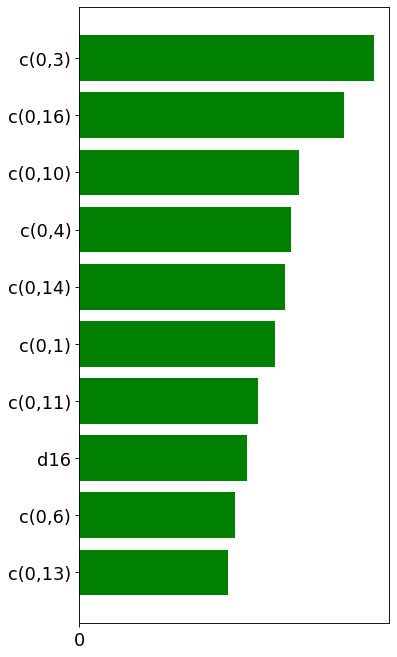

In [228]:
# Draw plot 
pyplt.figure(figsize=(5, 10), dpi=80) 
pyplt.rcParams.update({
    'font.size': 16,              # Base font size
    'axes.labelsize': 16,         # Axis label size
    'xtick.labelsize': 16,        # X-tick label size
    'ytick.labelsize': 16,        # Y-tick label size
    'legend.fontsize': 16,        # Legend text size
})
  
# Plotting the horizontal lines 
lst_sorted = sorted(lst)
lst_sorted_d = np.concatenate(([np.sum(lst_sorted[:5])], lst_sorted[:5]))
feature_names_sorted_d = np.concatenate((['others'], feature_names_sorted[:5]))
pyplt.barh(feature_names_sorted[-10:], lst_sorted[-10:], color = 'green')
pyplt.xticks(np.arange(0, 0.9, step=1))
# Displaying the Diverging Bar Chart 
pyplt.show() 

[('1', '0'), ('2', '0'), ('3', '0'), ('4', '0'), ('5', '0'), ('6', '0'), ('7', '0'), ('8', '0'), ('9', '0'), ('10', '0'), ('11', '0'), ('12', '0'), ('13', '0'), ('14', '0'), ('15', '0'), ('16', '0')]


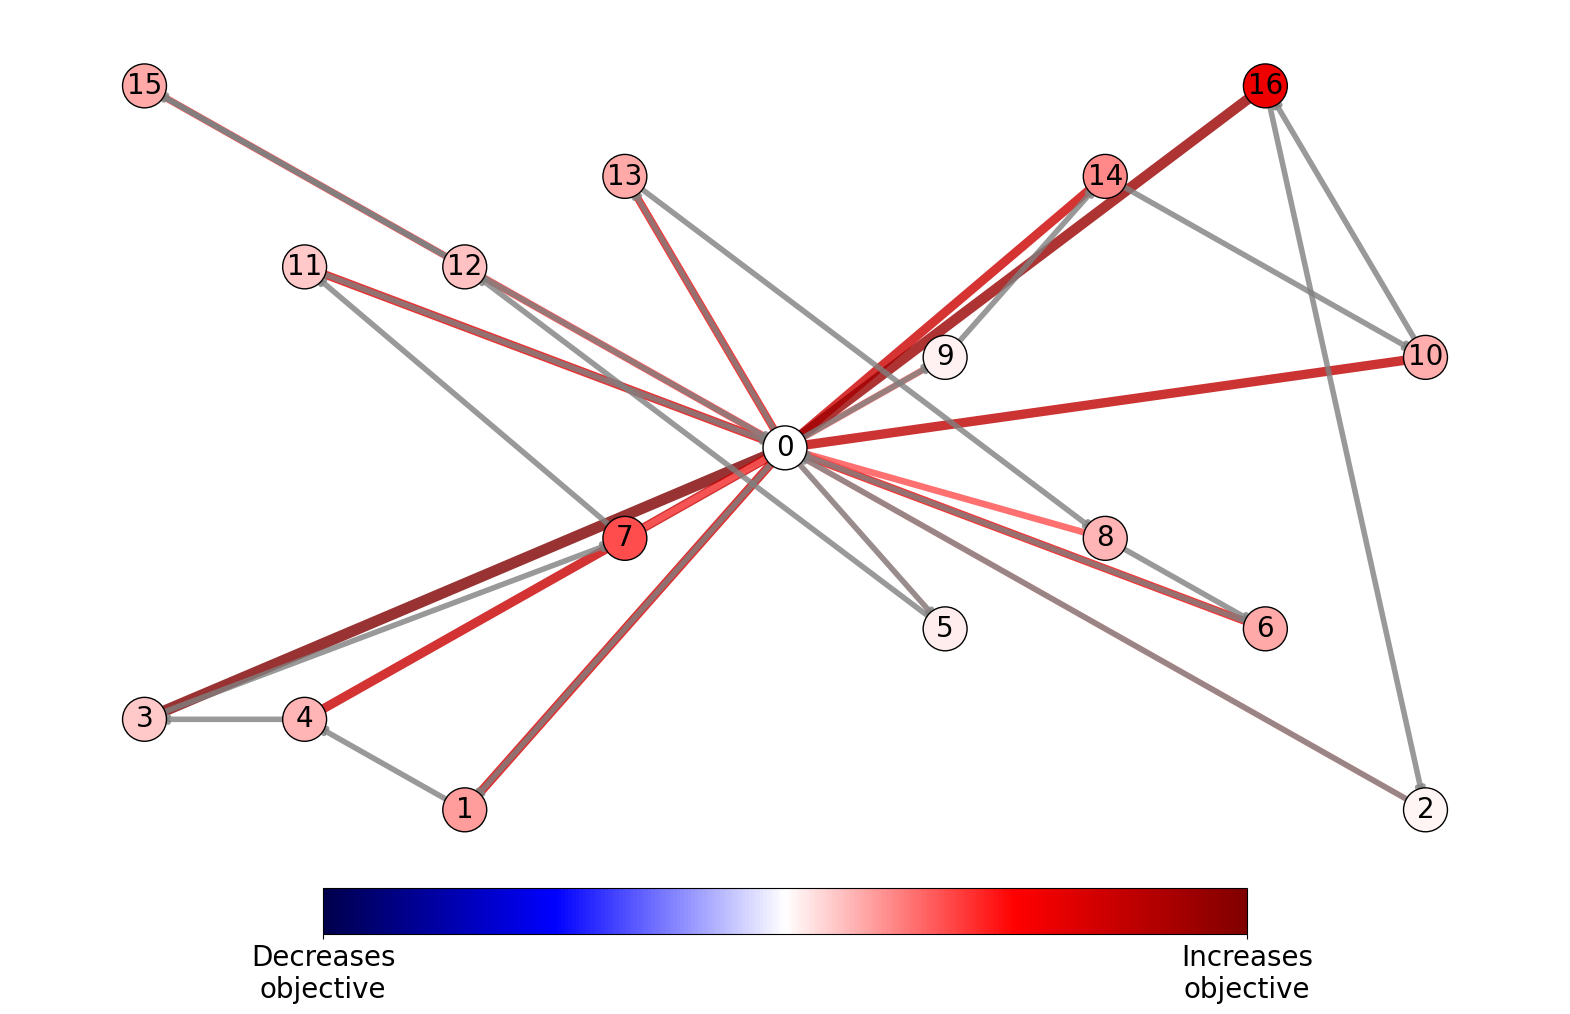

In [229]:
fig, ax = pyplt.subplots(figsize=(20,12))
# pyplt.figure(figsize=(25,10))

node_list_g = [*range(nr_lctns)]
node_list_g = [str(i) for i in node_list_g]
edge_list_g_all = []
edge_list_g_org = []
edge_list_g_adj = []
crdn_dict_g = {}

for i in range(len(node_list_g)):
    strt = node_list_g[i]
    crdn_dict_g[strt] = tuple(data['coordinates'][i])
    # print(tuple(data['coordinates'][i]))
    for j in range(len(node_list_g)):
        if i !=j and j == 0:
            edge_list_g_adj.append((str(i),str(j)))

for i in range(len(edge_list)):
    if actuals['x_vct'][0][i] == 1:
        edge = (str(edge_list[i][0]), str(edge_list[i][1]))
        edge_list_g_org.append(edge)

color_node = colors[:nr_lctns]
width_node = []
for i in range(nr_lctns):
    width_node.append(400+100*feature_magnitude[i])
width_edge = []
for i in range(nr_lctns, len(feature_contribution)):
    width_edge.append(5* feature_magnitude[i]+3)
color_egde = colors[nr_lctns:]
print(edge_list_g_adj)

G = nx.Graph()
draw = nx.draw_networkx_nodes(G, crdn_dict_g, nodelist =node_list_g, node_size=1000, node_color=color_node, edgecolors = "black")
nx.draw_networkx_edges(
    G,
    pos=crdn_dict_g,
    node_size=1000,
    edgelist=edge_list_g_adj,
    edge_color=color_egde,
    width=width_edge,
    alpha=0.8
)
draw = nx.draw_networkx_edges(
    G,
    pos=crdn_dict_g,
    edgelist=edge_list_g_org,
    edge_color='grey',
    width=4,
    arrows=True,
    arrowstyle="->",
    arrowsize=10,
    alpha=0.8,
)

labels = {}
for i in range(len(node_list_g)):
    labels[node_list_g[i]] = node_list_g[i]
nx.draw_networkx_labels(G, crdn_dict_g, labels, font_size=20, font_color="black")

cmap = pyplt.cm.seismic
norm = plt.colors.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array

# Add a colorbar to the plot
# plt.colorbar(im,fraction=0.046, pad=0.04)
cbar = pyplt.colorbar(sm,ax=ax, ticks=[-1, 1], orientation='horizontal',fraction=0.05, pad=0.002)
cbar.ax.set_xticklabels(['Decreases\nobjective', 'Increases\nobjective'], fontsize=20)
cbar.ax.xaxis.set_ticks_position('bottom')
ax.axis("off")
pyplt.show()